<a href="https://colab.research.google.com/github/haru1290/signate-student-cup-2023/blob/main/notebook/ssc2023_lgbm_v003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIGNATE Student Cup 2023【モデリング部門】：中古車の価格予測チャレンジ

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/repos/signate-student-cup-2023/

/content/drive/MyDrive/repos/signate-student-cup-2023


## 1. Downloading Dataset

In [3]:
# !pip install signate

In [4]:
# !signate token --email="###" --password="###"

In [5]:
# !signate download --competition-id=1051 --path="/content/drive/MyDrive/repos/signate-stuent-cup-2023/input"

## 2. Importing Modules

In [6]:
from pathlib import Path

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GroupKFold, KFold
from sklearn.pipeline import Pipeline

In [7]:
path = Path.cwd()
train_df = pd.read_csv(path.joinpath("input", "train.csv"))
test_df = pd.read_csv(path.joinpath("input", "test.csv"))
submit_df = pd.read_csv(path.joinpath("input", "submit_sample.csv"), names=["id", "price"])

## 3. Preprocessing Data

In [8]:
def clean_text(df):
    manufacturer_map = {
        "niѕsan": "nissan",
        "nisѕan": "nissan",
        "subαru": "subaru",
        "toyotа": "toyota",
        "sαturn": "saturn",
        "аcura": "acura",
        "vоlkswagen": "volkswagen",
        "lexuѕ": "lexus",
        # "ᴄhrysler": "chrysler",
    }
    df["manufacturer"] = df["manufacturer"].str.normalize("NFKC").str.lower()
    df["manufacturer"] = df["manufacturer"].replace(manufacturer_map)

    df["size"] = df["size"].str.replace("ー", "-")
    df["size"] = df["size"].str.replace("−", "-")

    return df

def encode_categorical_variables(df):
    df["cylinders"] = df["cylinders"].str.extract("(\d+)?")

    return df

def handle_missing_values(df):
    region_state_map = {}
    for region, state in df.groupby("region")["state"].apply(np.array).items():
        if pd.isna(state).all() == False:
            state = state[~pd.isna(state)]
            region_state_map[region] = state[0]

    region_state_map.update(
        {
            "ashtabula": "oh",
            "northwest KS": "ks",
            "southern WV": "wv",
            "glens falls": "ny",
            "hanford-corcoran": "ca",
        }
    )
    df["state"] = df["region"].map(region_state_map)

    return df

def handle_outliers(df):
    df["year"] = df["year"].apply(lambda x: x - 1000 if x > 2023 else x)

    df["odometer"] = df["odometer"].apply(abs)
    df["odometer"] = df["odometer"].apply(lambda x: x // 10 if x > 10e6 else x)

    return df

In [9]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # テキストのクリーニング
        X_new = clean_text(X_new)

        # 数値データの抽出
        X_new = encode_categorical_variables(X_new)

        # 欠損値の修正
        X_new = handle_missing_values(X_new)

        # 外れ値処理
        X_new = handle_outliers(X_new)

        # 年間の平均走行距離
        X_new["odometer_per_year"] =  X_new["odometer"] / (2023 - X_new["year"])

        return X_new

In [10]:
class OriginalTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, numerical_cols, categorical_cols):
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numerical_cols] = X_new[self.numerical_cols].astype("float64")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.numerical_cols + self.categorical_cols

In [11]:
class AggTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, key, numerical_cals, agg_func: list):
        self.key = key
        self.numerical_cals = numerical_cals
        self.agg_func = agg_func

    def fit(self, X, y=None):
        self.agg_df = X.groupby(self.key)[self.numerical_cals].agg(self.agg_func)
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.values]
        return self

    def transform(self, X):
        X_new = X.copy()
        X_new = pd.merge(X_new, self.agg_df, on=self.key, how="left")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.agg_df.columns.values

In [12]:
numerical_cols = ["year", "odometer", "odometer_per_year"]
categorical_cols = [
    # "region",
    "manufacturer",
    "condition",
    "cylinders",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    # "state",
]

ct = ColumnTransformer(
    [
        (
            "ori",
            OriginalTransformer(numerical_cols, categorical_cols),
            numerical_cols + categorical_cols,
         ),
        *[
            (f"agg_{key}", AggTransformer(key, ["odometer"], ["mean"]), [key] + ["odometer"])
            for key in [
                "state",
            ]
        ],
    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    [
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)
X_train = pipe.fit_transform(train_df, train_df["price"])
X_test = pipe.transform(test_df)

[ColumnTransformer] ........... (1 of 2) Processing ori, total=   0.1s
[ColumnTransformer] ..... (2 of 2) Processing agg_state, total=   0.0s


## 4. Stacking LighGBM

In [13]:
def get_cv1(df, n_splits: int = 5, random_state: int = 42):
    kf = GroupKFold(n_splits=n_splits)
    return list(kf.split(df, train_df["price"], handle_missing_values(train_df)["state"]))

def get_cv2(df, n_splits: int = 5, random_state: int = 42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    return list(kf.split(df))

def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: bool = False):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_tr, idx_va) in enumerate(cv):
        X_tr, X_va = X.iloc[idx_tr], X.iloc[idx_va]
        y_tr, y_va = y.iloc[idx_tr], y.iloc[idx_va]

        model = lgbm.LGBMRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            callbacks=[lgbm.early_stopping(100, verbose=verbose)],
            categorical_feature=categorical_cols,
        )

        va_pred = model.predict(X_va)
        oof_pred[idx_va] = va_pred
        models.append(model)
        score = mean_absolute_percentage_error(y_va, va_pred)
        print(f" - fold{i + 1} - {score * 100:.7f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score * 100:.7f}")
    return score, oof_pred, models

In [14]:
lgb_params = {
    "objective": "mape",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "max_depth": 5,
    "min_child_weight": 0.2079071475866748,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "reg_alpha": 0.00034599581038902334,
    "reg_lambda": 1.6372456235266806,
    "random_state": 42,
    "importance_type": "gain",
    "verbose": -1,
}

cv = get_cv1(X_train, n_splits=5, random_state=42)

score_1a, oof_1a, models_1a = fit_lgbm(
    X_train,
    y=train_df["price"],
    cv=cv,
    categorical_cols=["ori__" + col for col in categorical_cols],
    params=lgb_params,
)

 - fold1 - 44.0613329
 - fold2 - 43.8084784
 - fold3 - 44.8892685
 - fold4 - 43.7466132
 - fold5 - 44.5615231
FINISHI: Whole Score: 44.2134789


In [15]:
lgb_params = {
    "objective": "regression",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "max_depth": 5,
    "min_child_weight": 0.2079071475866748,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "reg_alpha": 0.00034599581038902334,
    "reg_lambda": 1.6372456235266806,
    "random_state": 42,
    "importance_type": "gain",
    "verbose": -1,
}

cv = get_cv1(X_train, n_splits=5, random_state=42)

score_1b, oof_1b, models_1b = fit_lgbm(
    X_train,
    y=train_df["price"],
    cv=cv,
    categorical_cols=["ori__" + col for col in categorical_cols],
    params=lgb_params,
)

 - fold1 - 63.7308322
 - fold2 - 62.4522155
 - fold3 - 70.1754556
 - fold4 - 67.6887102
 - fold5 - 65.2147402
FINISHI: Whole Score: 65.8499889


In [16]:
lgb_params = {
    "objective": "regression_l1",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "max_depth": 5,
    "min_child_weight": 0.2079071475866748,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "reg_alpha": 0.00034599581038902334,
    "reg_lambda": 1.6372456235266806,
    "random_state": 42,
    "importance_type": "gain",
    "verbose": -1,
}

cv = get_cv1(X_train, n_splits=5, random_state=42)

score_1c, oof_1c, models_1c = fit_lgbm(
    X_train,
    y=train_df["price"],
    cv=cv,
    categorical_cols=["ori__" + col for col in categorical_cols],
    params=lgb_params,
)

 - fold1 - 52.8732389
 - fold2 - 51.6462978
 - fold3 - 56.0851520
 - fold4 - 55.0519864
 - fold5 - 53.4766152
FINISHI: Whole Score: 53.8252520


In [17]:
lgb_params = {
    "objective": "poisson",
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "max_depth": 5,
    "min_child_weight": 0.2079071475866748,
    "subsample": 0.7,
    "colsample_bytree": 0.6,
    "reg_alpha": 0.00034599581038902334,
    "reg_lambda": 1.6372456235266806,
    "random_state": 42,
    "importance_type": "gain",
    "verbose": -1,
}

cv = get_cv1(X_train, n_splits=5, random_state=42)

score_1d, oof_1d, models_1d = fit_lgbm(
    X_train,
    y=train_df["price"],
    cv=cv,
    categorical_cols=["ori__" + col for col in categorical_cols],
    params=lgb_params,
)

 - fold1 - 63.7000085
 - fold2 - 62.4130860
 - fold3 - 68.9666060
 - fold4 - 67.6356588
 - fold5 - 65.3909090
FINISHI: Whole Score: 65.6192032


In [18]:
X_train_1 = pd.DataFrame()
X_test_1 = pd.DataFrame()
for k, (oof_v, models_v) in {
    "a": (oof_1a, models_1a),
    "b": (oof_1b, models_1b),
    "c": (oof_1c, models_1c),
    "d": (oof_1d, models_1d)
}.items():
    X_train_1[f"feat_1{k}"] = oof_v
    pred = np.array([model.predict(X_test) for model in models_v])
    X_test_1[f"feat_1{k}"] = np.mean(pred, axis=0)

In [19]:
ensemble_oof = []
ensemble_models = []
for i in range(5):
    lgb_params = {
        "objective": "mape",
        "learning_rate": 0.01,
        "n_estimators": 10000,
        "max_depth": 3,
        "min_child_weight": 0.2837885619235051,
        "subsample": 0.9,
        "colsample_bytree": 0.75,
        "reg_alpha": 0.0013207396755076433,
        "reg_lambda": 0.015242312409459731,
        "random_state": 42 + i,
        "importance_type": "gain",
        "verbose": -1,
    }

    cv = get_cv2(X_train_1, n_splits=5, random_state=42 + i)

    score, oof, models = fit_lgbm(
        X_train_1,
        y=train_df["price"],
        cv=cv,
        categorical_cols=[],
        params=lgb_params,
    )
    ensemble_oof.append(oof)
    ensemble_models += models

 - fold1 - 44.1564846
 - fold2 - 42.8582590
 - fold3 - 44.5351595
 - fold4 - 44.1747926
 - fold5 - 43.8521585
FINISHI: Whole Score: 43.9153412
 - fold1 - 44.7382229
 - fold2 - 44.1338665
 - fold3 - 43.0638098
 - fold4 - 44.0734828
 - fold5 - 43.6380303
FINISHI: Whole Score: 43.9295193
 - fold1 - 44.0746573
 - fold2 - 43.9894915
 - fold3 - 43.1696651
 - fold4 - 44.5381519
 - fold5 - 43.8229351
FINISHI: Whole Score: 43.9189884
 - fold1 - 43.4064665
 - fold2 - 43.9291135
 - fold3 - 43.9951347
 - fold4 - 44.1083763
 - fold5 - 44.2029698
FINISHI: Whole Score: 43.9283932
 - fold1 - 43.6220329
 - fold2 - 43.8665863
 - fold3 - 43.8948699
 - fold4 - 44.0320847
 - fold5 - 44.0961677
FINISHI: Whole Score: 43.9023368


In [20]:
# evaluation
score = mean_absolute_percentage_error(train_df["price"], np.mean(ensemble_oof, axis=0))
print(f" - ENSEMBLE - {score * 100:.7f}")

 - ENSEMBLE - 43.8865603


In [21]:
# inference
pred = np.array([model.predict(X_test_1) for model in ensemble_models])
pred = np.mean(pred, axis=0)

In [22]:
# submission
submit_df["price"] = pred
submit_df.to_csv(path.joinpath("submission", "final_submission.csv"), index=False, header=False)

## 5. Visualizing

In [23]:
def visualize_importance(models, train_feat_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = train_feat_df.columns
        _df["forld"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        orient="h",
        palette="viridis",
        ax=ax,
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))
    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Importance'}, xlabel='feature_importance', ylabel='column'>)

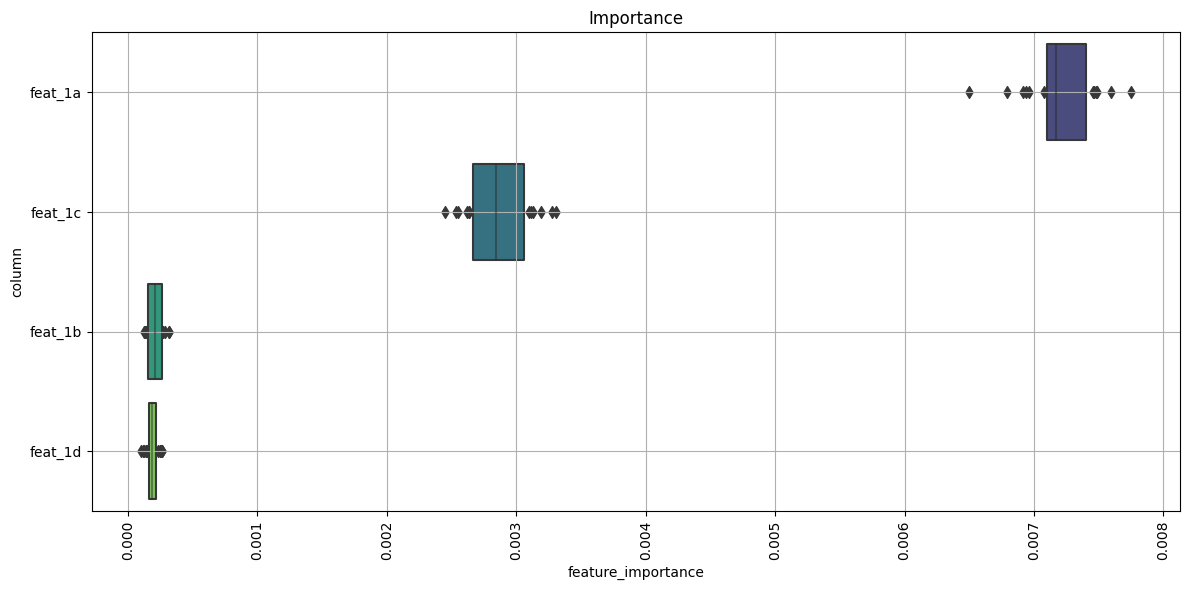

In [24]:
visualize_importance(ensemble_models, X_train_1)

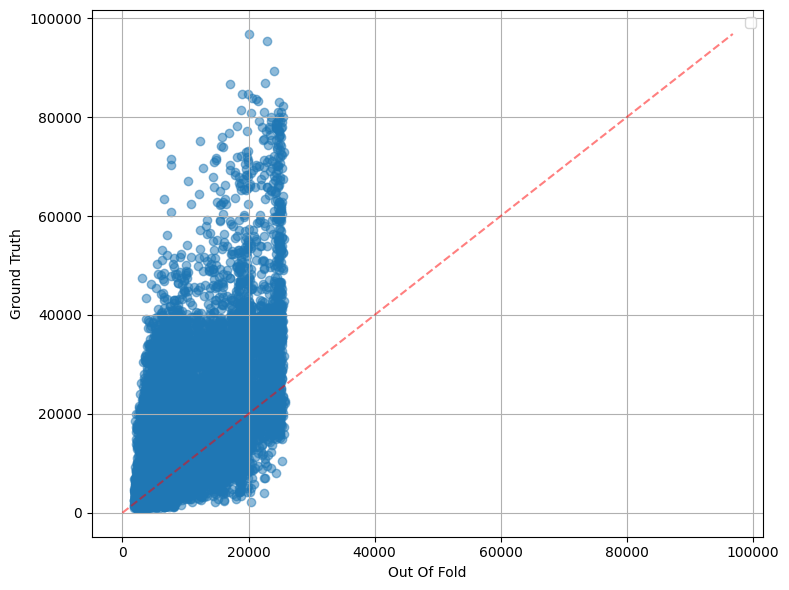

In [25]:
visualize_oof_gt(np.mean(ensemble_oof, axis=0), train_df["price"])

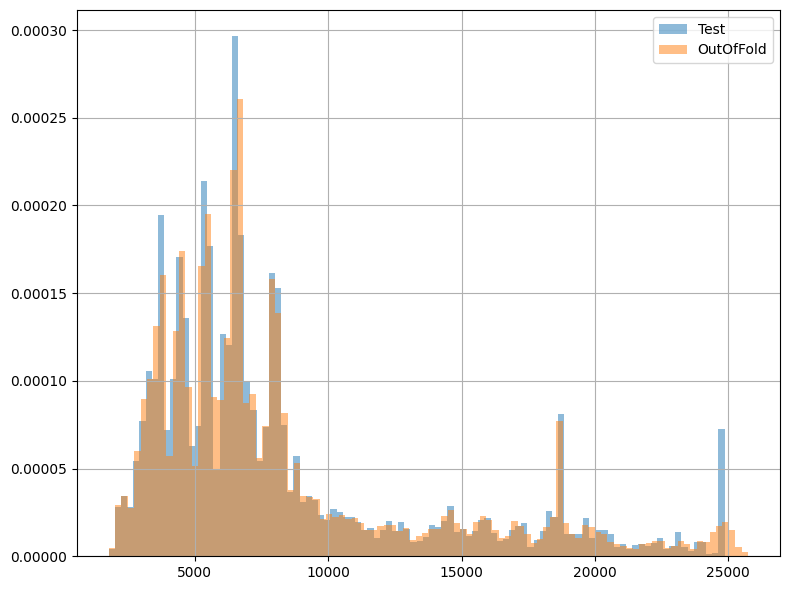

In [26]:
visualize_oof_pred(np.mean(ensemble_oof, axis=0), pred)